# Big Data in Finance: Part II <BR><BR> Lecture Notes 9: Compustat 
    
**Instructor** <BR>
Lira Mota, lmota20@gsb.columbia.edu
    
**TA's:** <BR>
Daheng Yang, dyang22@gsb.columbia.edu

# Compustat

In this section we are going to:
1. Download a set of US firm's annual fundamentals;
2. Understand how the data is organized:
    1. Primary keys;
    2. Secondary keys;
    3. Data frequency;
    4. Others.        
2. Clean the data;
3. Construct important variables:
    1. Book Equity Value
    2. Asset Growth
    3. Operational Profitability

## How is the fundamentals data organized?

* We can display all tables in "compm" library.
* We are going to focus on the "funda" table: annual fundamentals.
* Others that are interesting to know: "namesd"

## Set Up

In [2]:
%matplotlib inline 

#%% Packages 
import wrds
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]

import time
from time import strptime, strftime

# Setups
pd.set_option("display.max_rows", 200) # max number or rows to be displayed 

In [3]:
#%% Set WRDS Connection
db = wrds.Connection(wrds_username='lmota') # make sure to configure wrds connector before hand.

Loading library list...
Done


### All tables in compm

In [4]:
compm_tables = db.list_tables(library="compm") # compd: Compustat daily update

In [5]:
 pd.DataFrame({'tables':compm_tables}).head(100) # Transform libs to a Pandas data frame to have a better display.

tables
0           aco_amda
1           aco_imda
2        aco_indfnta
3        aco_indfntq
4      aco_indfntytd
5         aco_indsta
6         aco_indstq
7       aco_indstytd
8         aco_notesa
9         aco_notesq
10       aco_notessa
11      aco_notesytd
12        aco_pnfnda
13        aco_pnfndq
14      aco_pnfndytd
15        aco_pnfnta
16        aco_pnfntq
17      aco_pnfntytd
18        aco_transa
19        aco_transq
20       aco_transsa
21      aco_transytd
22          adsprate
23         asec_imda
24       asec_notesa
25       asec_notesq
26       asec_transa
27       asec_transq
28             chars
29       co_aacctchg
30         co_aaudit
31        co_adesind
32        co_adjfact
33          co_afnd1
34          co_afnd2
35        co_afnddc1
36        co_afnddc2
37       co_afntind1
38       co_afntind2
39        co_ainvval
40           co_amkt
41       co_busdescl
42         co_cotype
43       co_filedate
44        co_fortune
45           co_hgic
46       co_iacctchg
47         co_iaudit
48        co_idesind
49          co_ifndq
50         co_ifndsa
51        co_ifndytd
52          co_ifntq
53         co_ifntsa
54        co_ifntytd
55           co_imkt
56       co_industry
57           co_ipcd
58          co_mthly
59        co_offtitl
60           company
61          currency
62          dd_group
63     dd_group_xref
64           dd_item
65        dd_package
66        ecind_desc
67         ecind_mth
68          exrt_dly
69          exrt_mth
70             funda
71        funda_fncd
72             fundq
73        fundq_fncd
74           idx_ann
75        idx_anndes
76         idx_daily
77         idx_index
78           idx_mth
79           idx_qrt
80        idx_qrtdes
81        idxcst_his
82     io_qaggregate
83       io_qbuysell
84       io_qchanges
85      io_qfloatadj
86       io_qholders
87       it_mbuysell
88       it_msummary
89         it_r_rltn
90             names
91  names_aco_indsta
92  names_aco_indstq
93  names_aco_pnfnda
94  names_aco_pnfndq
95    names_adsprate
96          names_ix
97      names_ix_cst
98         names_seg
99            namesd

### All variables in compm.funda

In [6]:
db.describe_table(library="compm", table="funda")

Approximately 777983 rows in compm.funda.


name  nullable              type
0       gvkey      True        VARCHAR(6)
1    datadate      True              DATE
2       fyear      True  DOUBLE PRECISION
3      indfmt      True       VARCHAR(12)
4      consol      True        VARCHAR(2)
..        ...       ...               ...
943        au      True        VARCHAR(8)
944      auop      True        VARCHAR(8)
945    auopic      True        VARCHAR(1)
946     ceoso      True        VARCHAR(1)
947     cfoso      True        VARCHAR(1)

[948 rows x 3 columns]

#### Where to check variable definitions?
1. [Xpressfeed Data Items](https://wrds-web.wharton.upenn.edu/wrds/support/Data/_001Manuals%20and%20Overviews/_001Compustat/_001North%20America%20-%20Global%20-%20Bank/_000dataguide/index.cfm?_ga=2.238205512.977702200.1550764493-1500651139.1501534854)
2. WRDS website: go to the (?) sign
3. What if we want to replicate a paper that says:

   "Earnings (E) is income before extraordinary items (Item 18) plus income statement deferred taxes (Item 50) minus preferred dividends (Item 19), if earnings are positive;" [Baker and Wurgler, JF 2006](https://onlinelibrary.wiley.com/doi/epdf/10.1111/j.1540-6261.2006.00885.x)

    * All previous documentation does not contain ITEM numbers
    * These are the legacy CST item numbers
    * You can find item reference [here](http://www.crsp.com/products/documentation/annual-data-industrial).
    
    

**Objective**

Create a data frame with company fundamentals necessary to replicate FF 2015:

1. Book Equity (BE)
2. Operating Profits (OP)
3. Investment (INV)

# Choose variables of interest

Compustat XpressFeed Variables 1/5:  
* AT      = Total Assets  
* CAPX    = Capital Expenditures  
* CEQ     = Common/Ordinary Equity - Total 
* COGS    = Cost of Goods Sold
* CSHO    = Common Shares Outstanding
* DLC     = Debt in Current Liabilities 
* DLCCH   = Current Debt - Changes
* DLTT    = Long-Term Debt - Total

Compustat XpressFeed Variables 2/5:
* DP      = Depreciation and Amortization
* DVC     = Divdends common/ordinary  
* DVP     = Dividends - Preferred/Preference
* GP      = Gross Profits
* IB      = Income Before Extraordinary Items
* ICAPT   = Invested Capital - Total
* ITCB    = Investment Tax Credit (Balance Sheet)  
* LT      = Total Liabilities

Compustat XpressFeed Variables 3/5:
* MIB     = Minority Interest (Balance Sheet)
* NAICS   = North American Industrial Classification System Variable Name
* NAICSH  = North American Industry Classification Codes - Historical Company Variable Name
* NI      = Net Income
* PPEGT   = "Property, Plant and Equipment - Total (Gross)"
* PRBA    = Postretirement Benefit Assets (from separate pension annual file) 
* PRSTKCC = Purchase of Common Stock (Cash Flow)                   
* PSTKRV  = Preferred Stock Redemption Value

Compustat XpressFeed Variables 4/5:
* PSTK    = Preferred/Preference Stock (Capital) - Total (kd: = par?)               
* PSTKL   = Preferred Stock Liquidating Value     
* PSTKRV  = Preferred Stock Liquidating Value          
* RE      = Retained Earnings
* REVT    = Revenue - Total
* SALE    = Sales/Turnover Net
* SEQ     = Shareholders Equity   
* SIC     = Standard Industrial Classification Code

Compustat XpressFeed Variables 5/5:
* TXDB    = Deferred Taxes Balance Sheet
* TXDI    = Income Taxes - Deferred
* TXDITC  = Deferred Taxes and Investment Tax Credit                        
* WCAPCH  = Working Capital Change - Total
* XINT    = Interest and Related Expense - Total 
* XLR     = Staff Expense - Total
* XRD     = Research and Development Expense 
* XSGAQ   = Selling, General and Administrative Expenses (millions)  

# Download Compustat FUNDA

In [6]:
fund_table = 'funda'

varlist = ['conm', 'fyear', 'fyr', 'at','capx', 'ceq', 'cogs', 'csho', 'dlc', 'dlcch','dltt', 'dp', 'ib', 'itcb', 
           'lt', 'mib', 'naicsh', 'ni', 'prstkcc', 'pstk', 'pstkl', 'pstkrv', 're', 'revt', 'sale', 
           'seq', 'sich', 'txdb', 'txdi', 'txditc', 'wcapch', 'xint', 'xlr', 'xrd', 'xsga']


query = """SELECT gvkey, datadate, {}
           FROM compm.{}
           WHERE datafmt = 'STD'
           AND popsrc = 'D'
           AND indfmt = 'INDL'
           AND consol = 'C'
           AND fyear>=1980;""".format(", ".join(varlist), fund_table)

compa = db.raw_sql(query, date_cols=['datadate'])

del(fund_table, varlist, query)

Always look at your data

In [7]:
# Gerneral Look
compa.head() 

gvkey   datadate                     conm   fyear   fyr      at   capx  \
0  001001 1980-12-31  A & M FOOD SERVICES INC  1980.0  12.0     NaN    NaN   
1  001001 1981-12-31  A & M FOOD SERVICES INC  1981.0  12.0     NaN    NaN   
2  001001 1982-12-31  A & M FOOD SERVICES INC  1982.0  12.0     NaN    NaN   
3  001001 1983-12-31  A & M FOOD SERVICES INC  1983.0  12.0  14.080  3.367   
4  001001 1984-12-31  A & M FOOD SERVICES INC  1984.0  12.0  16.267  5.496   

     ceq   cogs   csho  ...    seq  sich   txdb   txdi  txditc  wcapch   xint  \
0    NaN    NaN    NaN  ...    NaN   NaN    NaN    NaN     NaN     NaN    NaN   
1    NaN    NaN    NaN  ...    NaN   NaN    NaN    NaN     NaN     NaN    NaN   
2    NaN    NaN    NaN  ...    NaN   NaN    NaN    NaN     NaN     NaN    NaN   
3  7.823  6.310  3.568  ...  7.823   NaN  0.000  0.144   0.000   3.618  0.763   
4  8.962  8.171  3.568  ...  8.962   NaN  0.357  0.275   0.357  -2.993  0.661   

   xlr  xrd    xsga  
0  NaN  NaN     NaN  
1  NaN  NaN     NaN  
2  NaN  NaN     NaN  
3  NaN  0.0  16.435  
4  NaN  NaN  20.628  

[5 rows x 37 columns]

In [8]:
# Have a sense about missings
compa['at'].isnull().mean()*100

14.926082484855648

In [9]:
compa.gvkey.nunique()

36122

In [10]:
compa.groupby('fyear').gvkey.nunique()

fyear
1980.0     6889
1981.0     7058
1982.0     7685
1983.0     7996
1984.0     8243
1985.0     8599
1986.0     9017
1987.0     9225
1988.0     9333
1989.0     9343
1990.0     9571
1991.0     9966
1992.0    10705
1993.0    11482
1994.0    11899
1995.0    12492
1996.0    12624
1997.0    12438
1998.0    12555
1999.0    12531
2000.0    12093
2001.0    11584
2002.0    11251
2003.0    11064
2004.0    10897
2005.0    10854
2006.0    10881
2007.0    10981
2008.0    10862
2009.0    10834
2010.0    11074
2011.0    11683
2012.0    11871
2013.0    11804
2014.0    11560
2015.0    11255
2016.0    10747
2017.0     6725
Name: gvkey, dtype: int64

# Data Consistency 

## Primary Keys


* We are looking at Annual data
* Logic says that that we should have one company (gvkey) per year (fyear)
* But remember, the primary key for funda is (gvkey and datadate)
* Question: Can a firm have two datadate for the same year?


In [11]:
# It is always good to check if we have the right PK
compa.duplicated(['gvkey', 'datadate']).sum()

0

In [12]:
# Is (gvkey, fyear) PK?
compa[compa.duplicated(['gvkey', 'fyear'])]

gvkey   datadate                       conm   fyear   fyr  at  capx  \
63888  006557 1982-12-31  LAIDLAW INTERNATIONAL INC  1982.0  12.0 NaN   NaN   
63890  006557 1983-12-31  LAIDLAW INTERNATIONAL INC  1983.0  12.0 NaN   NaN   

       ceq  cogs  csho  ...  seq  sich  txdb  txdi  txditc  wcapch  xint  xlr  \
63888  NaN   NaN   NaN  ...  NaN   NaN   NaN   NaN     NaN     NaN   NaN  NaN   
63890  NaN   NaN   NaN  ...  NaN   NaN   NaN   NaN     NaN     NaN   NaN  NaN   

       xrd  xsga  
63888  NaN   NaN  
63890  NaN   NaN  

[2 rows x 37 columns]

In [13]:
compa[compa.gvkey=='006557']

gvkey   datadate                       conm   fyear   fyr        at  \
63885  006557 1980-08-31  LAIDLAW INTERNATIONAL INC  1980.0   8.0   201.266   
63886  006557 1981-08-31  LAIDLAW INTERNATIONAL INC  1981.0   8.0   242.081   
63887  006557 1982-08-31  LAIDLAW INTERNATIONAL INC  1982.0   8.0   251.360   
63888  006557 1982-12-31  LAIDLAW INTERNATIONAL INC  1982.0  12.0       NaN   
63889  006557 1983-08-31  LAIDLAW INTERNATIONAL INC  1983.0   8.0   328.891   
63890  006557 1983-12-31  LAIDLAW INTERNATIONAL INC  1983.0  12.0       NaN   
63891  006557 1984-08-31  LAIDLAW INTERNATIONAL INC  1984.0   8.0   426.880   
63892  006557 1985-08-31  LAIDLAW INTERNATIONAL INC  1985.0   8.0   652.477   
63893  006557 1986-08-31  LAIDLAW INTERNATIONAL INC  1986.0   8.0   901.769   
63894  006557 1987-08-31  LAIDLAW INTERNATIONAL INC  1987.0   8.0  1655.019   
63895  006557 1988-08-31  LAIDLAW INTERNATIONAL INC  1988.0   8.0  1636.927   
63896  006557 1989-08-31  LAIDLAW INTERNATIONAL INC  1989.0   8.0  2651.276   
63897  006557 1990-08-31  LAIDLAW INTERNATIONAL INC  1990.0   8.0  3894.939   
63898  006557 1991-08-31  LAIDLAW INTERNATIONAL INC  1991.0   8.0  3595.316   
63899  006557 1992-08-31  LAIDLAW INTERNATIONAL INC  1992.0   8.0  3658.935   
63900  006557 1993-08-31  LAIDLAW INTERNATIONAL INC  1993.0   8.0  3575.082   
63901  006557 1994-08-31  LAIDLAW INTERNATIONAL INC  1994.0   8.0  3633.200   
63902  006557 1995-08-31  LAIDLAW INTERNATIONAL INC  1995.0   8.0  4286.300   
63903  006557 1996-08-31  LAIDLAW INTERNATIONAL INC  1996.0   8.0  4932.300   
63904  006557 1997-08-31  LAIDLAW INTERNATIONAL INC  1997.0   8.0  6117.100   
63905  006557 1998-08-31  LAIDLAW INTERNATIONAL INC  1998.0   8.0  6184.600   
63906  006557 1999-08-31  LAIDLAW INTERNATIONAL INC  1999.0   8.0  5754.300   
63907  006557 2000-08-31  LAIDLAW INTERNATIONAL INC  2000.0   8.0  4000.100   
63908  006557 2001-08-31  LAIDLAW INTERNATIONAL INC  2001.0   8.0  4209.800   
63909  006557 2002-08-31  LAIDLAW INTERNATIONAL INC  2002.0   8.0  4091.100   
63910  006557 2003-08-31  LAIDLAW INTERNATIONAL INC  2003.0   8.0  3852.700   
63911  006557 2004-08-31  LAIDLAW INTERNATIONAL INC  2004.0   8.0  3905.200   
63912  006557 2005-08-31  LAIDLAW INTERNATIONAL INC  2005.0   8.0  2908.700   
63913  006557 2006-08-31  LAIDLAW INTERNATIONAL INC  2006.0   8.0  3038.700   

          capx       ceq      cogs     csho  ...       seq    sich     txdb  \
63885   38.344    50.957   174.256   11.584  ...    73.039     NaN   14.636   
63886   53.382    59.995   205.197   11.584  ...    81.481     NaN   18.192   
63887   47.089    63.491   213.686   11.584  ...    84.314     NaN   19.938   
63888      NaN       NaN       NaN      NaN  ...       NaN     NaN      NaN   
63889   78.264   103.481   232.581   26.168  ...   120.161     NaN   25.469   
63890      NaN       NaN       NaN      NaN  ...       NaN     NaN      NaN   
63891   93.098   177.188   294.318   30.453  ...   191.757     NaN   31.525   
63892  149.695   225.685   391.430   60.907  ...   357.124     NaN   34.765   
63893  149.687   406.137   508.171   66.907  ...   537.574     NaN   36.442   
63894  242.522   821.060   821.289  175.925  ...  1138.647  4953.0   38.797   
63895  244.666   755.048   799.756  189.488  ...   906.630  4953.0   43.807   
63896  187.868  1330.093   935.567  218.340  ...  1477.194  4953.0   63.812   
63897  271.309  1906.825  1135.242  239.056  ...  2053.867  4953.0   88.617   
63898  248.448  1672.454  1261.713  253.336  ...  1682.063  4953.0   89.781   
63899  208.723  1950.345  1306.123  277.188  ...  1959.954  4953.0   88.800   
63900  200.712  1543.701  1399.778  277.188  ...  1553.310  4953.0   43.904   
63901  273.000  1576.300  1509.100  277.188  ...  1585.900  4953.0   48.200   
63902  316.700  1688.100  1805.300  277.300  ...  1697.400  4953.0   46.000   
63903  289.100  2127.800  1720.500  313.820  ...  2136.800  4100.0  131.500   
63904  237.100  2785.300  2214.100  328.768  ...  2794.00

In [14]:
# Check duplicates
compa[compa.duplicated(['gvkey', 'fyear'],keep='last')]

gvkey   datadate                       conm   fyear  fyr       at  \
63887  006557 1982-08-31  LAIDLAW INTERNATIONAL INC  1982.0  8.0  251.360   
63889  006557 1983-08-31  LAIDLAW INTERNATIONAL INC  1983.0  8.0  328.891   

         capx      ceq     cogs    csho  ...      seq  sich    txdb   txdi  \
63887  47.089   63.491  213.686  11.584  ...   84.314   NaN  19.938  2.672   
63889  78.264  103.481  232.581  26.168  ...  120.161   NaN  25.469  5.533   

       txditc  wcapch    xint  xlr  xrd    xsga  
63887  19.938  13.777  14.309  NaN  NaN     NaN  
63889  25.469   3.109   8.879  NaN  NaN  17.218  

[2 rows x 37 columns]

In [15]:
# Example of a company that have two reports for the same year
compa.loc[compa.gvkey=='006557',['gvkey','datadate','fyear','fyr','conm', 'at']]

gvkey   datadate   fyear   fyr                       conm        at
63885  006557 1980-08-31  1980.0   8.0  LAIDLAW INTERNATIONAL INC   201.266
63886  006557 1981-08-31  1981.0   8.0  LAIDLAW INTERNATIONAL INC   242.081
63887  006557 1982-08-31  1982.0   8.0  LAIDLAW INTERNATIONAL INC   251.360
63888  006557 1982-12-31  1982.0  12.0  LAIDLAW INTERNATIONAL INC       NaN
63889  006557 1983-08-31  1983.0   8.0  LAIDLAW INTERNATIONAL INC   328.891
63890  006557 1983-12-31  1983.0  12.0  LAIDLAW INTERNATIONAL INC       NaN
63891  006557 1984-08-31  1984.0   8.0  LAIDLAW INTERNATIONAL INC   426.880
63892  006557 1985-08-31  1985.0   8.0  LAIDLAW INTERNATIONAL INC   652.477
63893  006557 1986-08-31  1986.0   8.0  LAIDLAW INTERNATIONAL INC   901.769
63894  006557 1987-08-31  1987.0   8.0  LAIDLAW INTERNATIONAL INC  1655.019
63895  006557 1988-08-31  1988.0   8.0  LAIDLAW INTERNATIONAL INC  1636.927
63896  006557 1989-08-31  1989.0   8.0  LAIDLAW INTERNATIONAL INC  2651.276
63897  006557 1990-08-31  1990.0   8.0  LAIDLAW INTERNATIONAL INC  3894.939
63898  006557 1991-08-31  1991.0   8.0  LAIDLAW INTERNATIONAL INC  3595.316
63899  006557 1992-08-31  1992.0   8.0  LAIDLAW INTERNATIONAL INC  3658.935
63900  006557 1993-08-31  1993.0   8.0  LAIDLAW INTERNATIONAL INC  3575.082
63901  006557 1994-08-31  1994.0   8.0  LAIDLAW INTERNATIONAL INC  3633.200
63902  006557 1995-08-31  1995.0   8.0  LAIDLAW INTERNATIONAL INC  4286.300
63903  006557 1996-08-31  1996.0   8.0  LAIDLAW INTERNATIONAL INC  4932.300
63904  006557 1997-08-31  1997.0   8.0  LAIDLAW INTERNATIONAL INC  6117.100
63905  006557 1998-08-31  1998.0   8.0  LAIDLAW INTERNATIONAL INC  6184.600
63906  006557 1999-08-31  1999.0   8.0  LAIDLAW INTERNATIONAL INC  5754.300
63907  006557 2000-08-31  2000.0   8.0  LAIDLAW INTERNATIONAL INC  4000.100
63908  006557 2001-08-31  2001.0   8.0  LAIDLAW INTERNATIONAL INC  4209.800
63909  006557 2002-08-31  2002.0   8.0  LAIDLAW INTERNATIONAL INC  4091.100
63910  006557 2003-08-31  2003.0   8.0  LAIDLAW INTERNATIONAL INC  3852.700
63911  006557 2004-08-31  2004.0   8.0  LAIDLAW INTERNATIONAL INC  3905.200
63912  006557 2005-08-31  2005.0   8.0  LAIDLAW INTERNATIONAL INC  2908.700
63913  006557 2006-08-31  2006.0   8.0  LAIDLAW INTERNATIONAL INC  3038.700

In [16]:
# How to deal with duplicates? Keep last available entry (datadate)
compa.dropna(subset=['fyear'], inplace=True)
compa.sort_values(['gvkey','fyear','at'], inplace=True)
compa = compa[~compa.duplicated(['gvkey', 'fyear'], keep='first')]

In [17]:
# Always check your result
compa.duplicated(['gvkey', 'fyear']).sum()

0

# Calculate Variables of Interest

## Book Equity

Daniel, Mota, Rottke, Santos (RFS, 2020) BE definition:

Stockholders book equity, minus the book value of preferred stock, plus balance sheet deferred taxes (if available and fiscal year is < 1993), minus investment tax credit (if available), minus post-retirement benefit assets (PRBA) if available. 

Stockholders book equity is shareholder equity (SEQ), common equity (CEQ) plus preferred stock (PSTK) or total
assets (AT) minus liabilities (LT) plus minority interest (MIB, if available) (depending on availability, in that order). 

Book value of preferred stock is redemption (PSTKRV), liquidation (PSTKL), or par value (PSTK) (depending on availability, in that order). 

Deferred taxes is deferred taxes and investment tax credit (TXDITC) or deferred taxes and investment tax credit (TXDB) plus investment tax credit (ITCB) (depending on availability, in that order).


In [18]:
#%% Calculating BE

# Shareholder Equity
compa['se'] = compa['seq']

# Uses Common Equity (ceq) + Preferred Stock (pstk) if SEQ is missing:
compa['se'].fillna((compa['ceq'] + compa['pstk']), inplace=True)

# Uses Total Assets (at) - Liabilities (lt) + Minority Interest (mib, if available), if others are missing
compa['se'].fillna((compa['at'] - compa['lt'] + compa['mib'].fillna(0)), inplace=True)
  

In [19]:
# Preferred Stock
# Preferred Stock (Redemption Value)
compa['ps'] = compa['pstkrv']
# Uses Preferred Stock (Liquidating Value (pstkl)) if Preferred Stock (Redemption Value) is missing
compa['ps'].fillna(compa['pstkl'], inplace=True)
# Uses Preferred Stock (Carrying Value (pstk)) if others are missing
compa['ps'].fillna(compa['pstk'], inplace=True)

In [20]:
# Deferred Taxes
# Uses Deferred Taxes and Investment Tax Credit (txditc)
compa['dt'] = compa['txditc']

# This was Novy-Marx old legacy code. We drop this part to be in accordance with Ken French.
# Uses Deferred Taxes and Investment Tax Credit(txdb) + Investment Tax Credit (Balance Sheet) (itcb) if txditc is missing
compa['dt'].fillna((compa['txdb'].fillna(0) + compa['itcb'].fillna(0)), inplace=True)
# If all measures are missing, set n  to missing
compa.loc[pd.isnull(compa['txditc']) & pd.isnull(compa['txdb']) & pd.isnull(compa['itcb']), 'dt'] = np.nan

compa.loc[compa['fyear'] >= 1993, 'dt'] = 0

In [21]:
# Book Equity
# Book Equity (BE) = Share Equity (se) - Prefered Stocks (ps) + Deferred Taxes (dt)
compa['be'] = (compa['se']  # shareholder equity must be available, otherwise BE is missing
               - compa['ps']  # preferred stock must be available, otherwise BE is missing
               + compa['dt'].fillna(0))  # add deferred taxes if available
               #- compa['prba'].fillna(0))  # subtract postretirement benefit assets if available

**Always look at your data...**

In [22]:
# Missings
compa.be.isnull().mean()  

0.15115761521458693

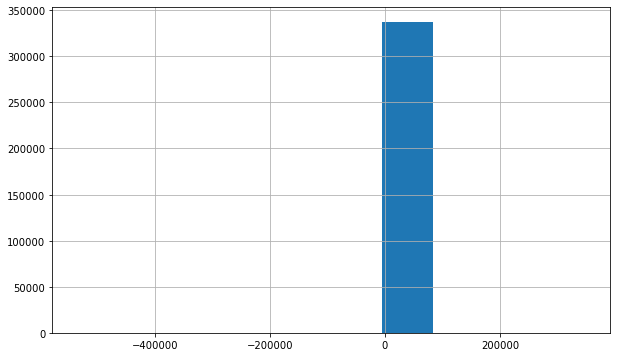

In [23]:
compa.be.hist() 

In [24]:
# Does it make sense to have a negative BE?
(compa.be<0).mean()   

0.09623030092714832

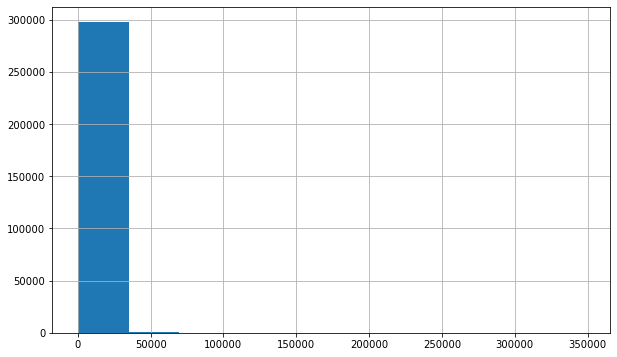

In [25]:
compa[compa.be>0].be.hist()

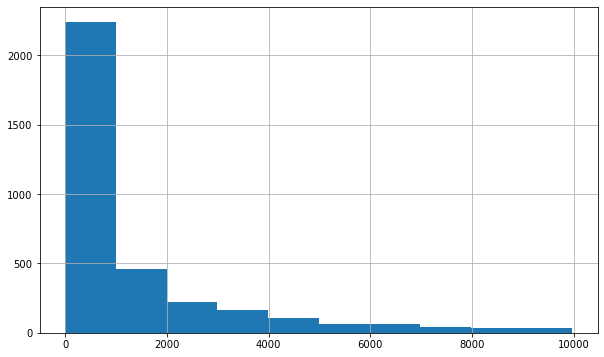

In [26]:
compa[(compa.be>0)&(compa.be<10e3)&(compa.fyear==2017)].be.hist()

## Operating Profitability (OPBE)

Daniel, Mota, Rottke, Santos (RFS, 2020) OPBE definition:

Operating profits to book equity (BE) ratio. 

Operating profits is sales (SALE) minus cost of goods sold (COGS), minus selling, general, and administrative expenses (XSGA),
minus interest expense (XINT). In order to be non-missing, SALE must be non-missing, at least one of the other entries must be non-missing and BE must be greater than zero.

In [27]:
# COST = COGS + XSGA - XINT 
compa['cost'] = compa[['cogs', 'xsga', 'xint']].sum(axis=1, skipna=True)
compa.loc[compa[['cogs', 'xsga', 'xint']].isnull().all(axis=1), 'cost'] = np.nan

In [28]:
compa[compa.cost<0].cost.mean()

-191.82889024390246

In [29]:
# OP = SALE -COST    
compa['op'] = compa['sale']-compa['cost']

**Always look at your data...**

In [30]:
# Look at missings
compa.op.isnull().mean()

0.1552841419163077

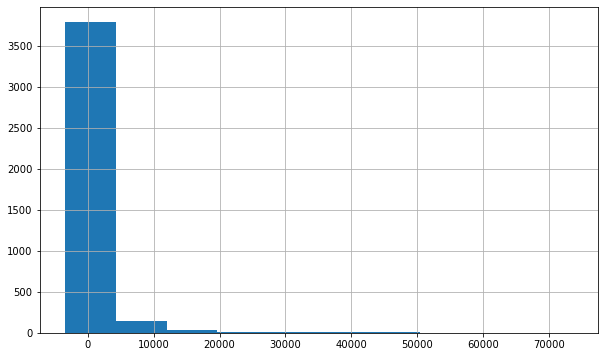

In [31]:
compa[compa.fyear==2017].op.hist()

In [32]:
# Which was the most profitable company in 2017?
compa.loc[compa[compa.fyear==2017].op.idxmax(),['gvkey','conm','op','be','at']]

gvkey         015532
conm     BNP PARIBAS
op           73500.1
be            122604
at       2.35661e+06
Name: 170529, dtype: object

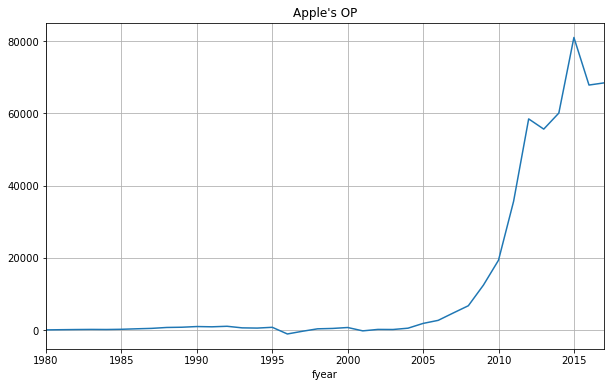

In [33]:
# Plot
compa[compa.gvkey=='001690'].set_index('fyear').op.plot(title = "Apple's OP", grid=True)

In [34]:
# Calculate OPBE
compa.loc[(compa.be > 0), 'opbe'] = compa['op']/compa['be']

**What do we do now?**

Look at the data...

In [35]:
# Look at missings
compa.opbe.isnull().mean()

0.2532596040445494

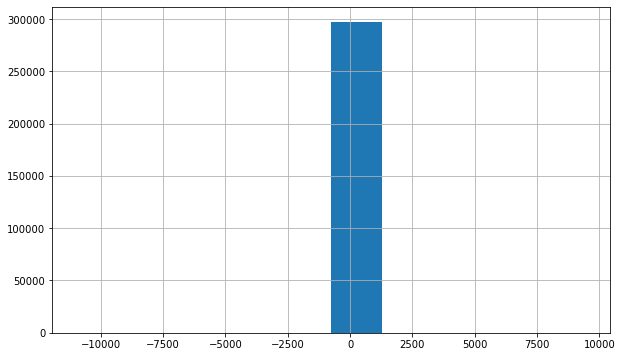

In [36]:
# Be careful with ratios
compa.opbe.hist()

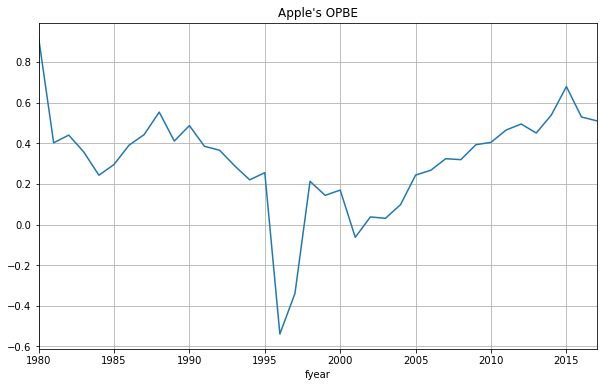

In [37]:
# Plot
compa[compa.gvkey=='001690'].set_index('fyear').opbe.plot(title = "Apple's OPBE", grid=True)

## Investment (INV)

Daniel, Mota, Rottke, Santos (RFS, 2020) OP definition:

Total asset (AT) growth $(AT_t/AT_{t-1} - 1)$. 

We consider PERMCO as company's identification key. AT must be greater than zero to be not missing.


In [38]:
# Calculate lag assets and investment
compa.sort_values(['gvkey', 'fyear'], inplace=True)
compa['at_lag'] = compa.groupby('gvkey').at.shift(1)
compa['inv'] = (compa['at'] - compa['at_lag']) / compa['at_lag']

In [39]:
compa.inv.max()

inf

In [40]:
compa.inv.min()

-1.0

In [41]:
compa.loc[compa.at_lag==0, 'inv'] = np.nan

What if compa has missing years?

In [42]:
compa['fdiff'] = compa.groupby('gvkey').fyear.diff()

In [43]:
compa[(compa.fdiff>1)][['gvkey','fyear','fdiff', 'at','at_lag', 'inv']]

gvkey   fyear  fdiff         at     at_lag        inv
20644   002820  2001.0    4.0    117.090        NaN        NaN
26382   003279  2011.0   19.0        NaN      1.269        NaN
28434   003469  2002.0    4.0    406.677        NaN        NaN
32152   003819  2011.0   19.0        NaN      2.295        NaN
34811   004049  2000.0    4.0    905.890        NaN        NaN
38384   004341  2000.0    2.0      0.000        NaN        NaN
39120   004412  2004.0    2.0    213.432    218.681  -0.024003
42654   004707  1996.0    3.0     14.416        NaN        NaN
48219   005202  1999.0   14.0      0.000      0.102  -1.000000
53398   005681  1995.0    4.0     26.851  13885.098  -0.998066
54621   005792  1998.0   13.0    218.462     84.850   1.574685
55068   005835  1997.0   16.0      0.030      3.052  -0.990170
56860   006000  2010.0   20.0        NaN      6.091        NaN
62221   006423  2011.0   22.0        NaN     38.823        NaN
62707   006464  1998.0   13.0      0.027      1.553  -0.982614
69389   007102  2011.0   19.0        NaN      1.687        NaN
70533   007185  2000.0    2.0    139.946    182.059  -0.231315
78436   007860  1998.0    2.0      0.423        NaN        NaN
82414   008145  2010.0   20.0        NaN     89.088        NaN
87880   008605  2001.0    3.0   2745.536        NaN        NaN
97287   009455  2007.0    4.0     17.965     20.144  -0.108171
97782   009493  2011.0   19.0        NaN      0.829        NaN
112967  010820  2011.0   19.0        NaN      1.138        NaN
116746  011137  2011.0   20.0        NaN     75.795        NaN
119032  011332  1998.0   11.0      0.054      2.970  -0.981818
122202  011611  1997.0   15.0      0.007      1.041  -0.993276
125171  011878  2011.0   19.0        NaN      0.875        NaN
127652  012132  1998.0   10.0      0.000      1.311  -1.000000
128047  012161  2011.0   19.0        NaN     77.187        NaN
129121  012286  1996.0    6.0      0.839      1.293  -0.351121
130049  012324  2010.0   18.0        NaN      0.138        NaN
134124  013212  2011.0   20.0        NaN     16.418        NaN
147279  013712  2009.0    2.0   1580.300        NaN        NaN
147548  013744  1990.0    4.0        NaN      1.028        NaN
149277  013936  1998.0    2.0      0.016        NaN        NaN
145872  013958  2011.0   21.0        NaN  11310.898        NaN
149838  013973  2005.0    6.0    121.222    751.055  -0.838598
150795  014038  2011.0   20.0        NaN     24.309        NaN
152555  014186  2001.0    4.0    160.347        NaN        NaN
156363  014488  2011.0   20.0        NaN   3453.626        NaN
154842  014546  1985.0    2.0     55.660        NaN        NaN
157434  014582  1998.0    2.0      0.085        NaN        NaN
157710  014608  2011.0   21.0        NaN     43.322        NaN
158222  014660  2007.0    3.0        NaN        NaN        NaN
161029  014783  2004.0   10.0        NaN        NaN        NaN
163199  014955  1997.0    9.0      0.747      6.741  -0.889186
162116  014995  2007.0    3.0        NaN        NaN        NaN
168919  015355  2011.0   21.0        NaN     88.760        NaN
172974  016445  2005.0    8.0        NaN        NaN        NaN
173550  016482  2010.0   20.0        NaN      2.202        NaN
181044  017238  2010.0   20.0        NaN      1.816        NaN
182547  017616  1998.0    6.0    159.707        NaN        NaN
193723  020305  2000.0    4.0   4430.102    637.436   5.949877
196340  020704  1994.0    2.0     13.574        NaN        NaN
197258  020866  1991.0    2.0     82.200        NaN        NaN
201202  021829  2011.0   21.0        NaN      5.289        NaN
201682  021943  2017.0    2.0        NaN        NaN        NaN
202904  022251  2011.0   20.0        NaN      2.535        NaN
208546  023714  1998.0    3.0   1747.016    567.713   2.077287
214767  024683  2006.0    2.0        NaN        NaN        NaN
215105  024739  2006.0    2.0        NaN        NaN        NaN
215618  024741  1999.0    2.0      0.286        NaN        NaN
216139  024787  1998.0    5.0    328.283

In [44]:
# Check one case of skipping years
compa.loc[compa.gvkey=='005681',['gvkey','fyear','at','at_lag','inv','fdiff']]  

gvkey   fyear         at     at_lag       inv  fdiff
53344  005681  1983.0   6803.074        NaN       NaN    NaN
53364  005681  1984.0   8885.500   6803.074  0.306101    1.0
53371  005681  1985.0  10018.598   8885.500  0.127522    1.0
53386  005681  1986.0  12074.598  10018.598  0.205218    1.0
53391  005681  1987.0  14109.098  12074.598  0.168494    1.0
51902  005681  1988.0  17008.699  14109.098  0.205513    1.0
52718  005681  1989.0  17766.699  17008.699  0.044565    1.0
52894  005681  1990.0  18259.500  17766.699  0.027737    1.0
53060  005681  1991.0  13885.098  18259.500 -0.239569    1.0
53398  005681  1995.0     26.851  13885.098 -0.998066    4.0
53399  005681  1996.0     17.091     26.851 -0.363487    1.0
53400  005681  1997.0     15.457     17.091 -0.095606    1.0
53402  005681  1998.0     19.043     15.457  0.231998    1.0
53403  005681  1999.0     27.528     19.043  0.445571    1.0
53404  005681  2000.0     24.818     27.528 -0.098445    1.0
53405  005681  2001.0     25.804     24.818  0.039729    1.0
53406  005681  2002.0    117.043     25.804  3.535847    1.0
53407  005681  2003.0    217.010    117.043  0.854105    1.0
53408  005681  2004.0    211.487    217.010 -0.025450    1.0
53409  005681  2005.0    294.261    211.487  0.391390    1.0
53410  005681  2006.0    237.299    294.261 -0.193576    1.0
53411  005681  2007.0    219.255    237.299 -0.076039    1.0
53412  005681  2008.0    190.397    219.255 -0.131618    1.0
53413  005681  2009.0    185.704    190.397 -0.024648    1.0
53414  005681  2010.0    184.510    185.704 -0.006430    1.0
53415  005681  2011.0    188.753    184.510  0.022996    1.0
53416  005681  2012.0    189.409    188.753  0.003475    1.0
53417  005681  2013.0    204.402    189.409  0.079157    1.0
53418  005681  2014.0    433.189    204.402  1.119299    1.0
53419  005681  2015.0    555.311    433.189  0.281914    1.0
53420  005681  2016.0    582.332    555.311  0.048659    1.0

In [45]:
# Input missings
filter_inv = (compa['at']<=0)|(compa['at_lag']<=0)|(compa.fdiff>1)
compa.loc[filter_inv,['inv']] = np.nan
del(filter_inv)

In [46]:
# Check one case of skipping years (again)
compa.loc[compa.gvkey=='005681',['gvkey','fyear','at','at_lag','inv']]

gvkey   fyear         at     at_lag       inv
53344  005681  1983.0   6803.074        NaN       NaN
53364  005681  1984.0   8885.500   6803.074  0.306101
53371  005681  1985.0  10018.598   8885.500  0.127522
53386  005681  1986.0  12074.598  10018.598  0.205218
53391  005681  1987.0  14109.098  12074.598  0.168494
51902  005681  1988.0  17008.699  14109.098  0.205513
52718  005681  1989.0  17766.699  17008.699  0.044565
52894  005681  1990.0  18259.500  17766.699  0.027737
53060  005681  1991.0  13885.098  18259.500 -0.239569
53398  005681  1995.0     26.851  13885.098       NaN
53399  005681  1996.0     17.091     26.851 -0.363487
53400  005681  1997.0     15.457     17.091 -0.095606
53402  005681  1998.0     19.043     15.457  0.231998
53403  005681  1999.0     27.528     19.043  0.445571
53404  005681  2000.0     24.818     27.528 -0.098445
53405  005681  2001.0     25.804     24.818  0.039729
53406  005681  2002.0    117.043     25.804  3.535847
53407  005681  2003.0    217.010    117.043  0.854105
53408  005681  2004.0    211.487    217.010 -0.025450
53409  005681  2005.0    294.261    211.487  0.391390
53410  005681  2006.0    237.299    294.261 -0.193576
53411  005681  2007.0    219.255    237.299 -0.076039
53412  005681  2008.0    190.397    219.255 -0.131618
53413  005681  2009.0    185.704    190.397 -0.024648
53414  005681  2010.0    184.510    185.704 -0.006430
53415  005681  2011.0    188.753    184.510  0.022996
53416  005681  2012.0    189.409    188.753  0.003475
53417  005681  2013.0    204.402    189.409  0.079157
53418  005681  2014.0    433.189    204.402  1.119299
53419  005681  2015.0    555.311    433.189  0.281914
53420  005681  2016.0    582.332    555.311  0.048659

**What do we do now?**

In [47]:
# Look at missings
compa.inv.isnull().mean()

0.23361773928699855

In [48]:
# Be careful with ratios
compa.loc[compa.inv.idxmax,['gvkey','conm','fyear','at','at_lag','inv']]

gvkey                    018073
conm      CHERRY HILL MTG INVST
fyear                      2013
at                      427.398
at_lag                    0.001
inv                      427397
Name: 184214, dtype: object

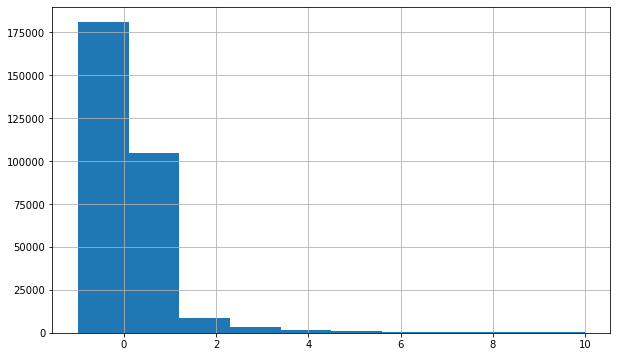

In [49]:
 # What explains such large inv?
compa[compa.inv<10].inv.hist() 

# Is Asset Growth Investment?

* See Cooper, Gulen, Schill, JF (2008);
* What is asset growth capturing other than investment? 
    * Mergers;
    * Issuance;
    * Spin-offs.
* Is it really investments that forecast future stock returns?

In [50]:
# A more traditional measure of investment: CAPX
compa['inv_capx'] = compa['capx']/compa['at_lag']
filter_inv_capx = (compa['capx']<=0)|(compa['at_lag']<=0)|(compa.fdiff>1)
compa.loc[filter_inv_capx,'inv_capx']=np.nan

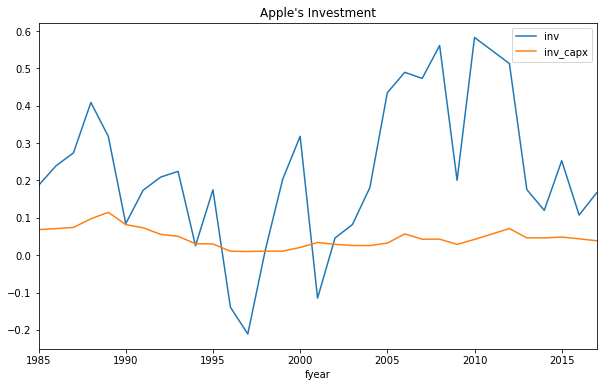

In [51]:
# Difference for Apple
compa.loc[(compa.gvkey=='001690')&
          (compa.fyear>=1985),['fyear','inv','inv_capx']
         ].set_index(['fyear']).plot(title="Apple's Investment") 

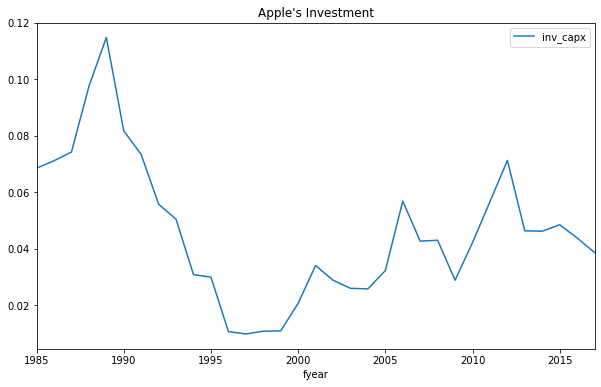

In [52]:
compa.loc[(compa.gvkey=='001690')&
          (compa.fyear>=1985),
          ['fyear','inv_capx']
         ].set_index(['fyear']).plot(title="Apple's Investment")

# Save Output

In [53]:
compa.columns

Index(['gvkey', 'datadate', 'conm', 'fyear', 'fyr', 'at', 'capx', 'ceq',
       'cogs', 'csho', 'dlc', 'dlcch', 'dltt', 'dp', 'ib', 'itcb', 'lt', 'mib',
       'naicsh', 'ni', 'prstkcc', 'pstk', 'pstkl', 'pstkrv', 're', 'revt',
       'sale', 'seq', 'sich', 'txdb', 'txdi', 'txditc', 'wcapch', 'xint',
       'xlr', 'xrd', 'xsga', 'se', 'ps', 'dt', 'be', 'cost', 'op', 'opbe',
       'at_lag', 'inv', 'fdiff', 'inv_capx'],
      dtype='object')

In [54]:
compa.to_pickle(path='/Users/liramertens/Dropbox/Columbia/BigData/class2020/lecture_outputs/compa_annual.pkl')